In [1]:
suppressPackageStartupMessages(require(tidyverse))
suppressPackageStartupMessages(require(data.table))
library(latex2exp)


In [2]:
outd <- file.path(getwd(), 'out_v3')

traits <- fread('cascade.input.files.tsv')


In [3]:
imp_anno_df <-
fread(cmd=paste('zstdcat', file.path(outd, 'cascade.imp.hits.tsv.zst'), sep=' '), sep='\t')


In [4]:
imp_anno_df %>% dim()

[1] 776  23

In [5]:
imp_anno_df %>% colnames()

[1] "ID"                "REF"               "ALT"              
 [4] "Effect"            "StdErr"            "Direction"        
 [7] "HetISq"            "HetChiSq"          "HetDf"            
[10] "HetPVal"           "maf"               "MACH_R2"          
[13] "CHROM"             "POS"               "P"                
[16] "CM"                "id"                "prev"             
[19] "block"             "name"              "is_outside_of_MHC"
[22] "is_rare"           "is_autosome"

In [6]:
array_anno_df <- 
fread(cmd=paste('zstdcat', file.path(outd, 'cascade.array.hits.tsv.zst'), sep=' '), sep='\t')


In [7]:
array_anno_df %>% dim()

[1] 9735   40

In [8]:
array_anno_df %>% colnames()

[1] "ID"                "Effect"            "StdErr"           
 [4] "P"                 "Direction"         "HetISq"           
 [7] "HetChiSq"          "HetDf"             "HetPVal"          
[10] "name"              "CHROM"             "POS"              
[13] "REF"               "ALT"               "Gene"             
[16] "Consequence"       "HGVSp"             "LoF"              
[19] "LoF_filter"        "LoF_flags"         "LoF_info"         
[22] "consequence_field" "f_miss"            "f_miss_bileve"    
[25] "f_miss_wcsg"       "freq"              "hwe_p"            
[28] "maf"               "ld_indep"          "wcsg_only"        
[31] "bileve_only"       "mgi"               "mgi_notes"        
[34] "all_filters"       "Gene_symbol"       "MAF"              
[37] "variant"           "Csq"               "is_outside_of_MHC"
[40] "is_rare"

In [10]:
common_cols <- intersect(names(array_anno_df), names(imp_anno_df))
common_cols

[1] "ID"                "Effect"            "StdErr"           
 [4] "P"                 "Direction"         "HetISq"           
 [7] "HetChiSq"          "HetDf"             "HetPVal"          
[10] "name"              "CHROM"             "POS"              
[13] "REF"               "ALT"               "maf"              
[16] "is_outside_of_MHC" "is_rare"

In [11]:
non_coding_df <- array_anno_df %>%
filter(Csq == 'non-coding') %>%
select(common_cols) %>%
bind_rows(imp_anno_df %>% select(common_cols))

In [12]:
non_coding_df %>% dim()

[1] 9130   17

In [15]:
p.imp <- non_coding_df %>% 
filter(is_outside_of_MHC) %>%
group_by(name) %>%
mutate(
    rank_abs_effect = rank(-abs(Effect))
) %>%
ungroup() %>%
mutate(
    outlier = if_else(abs(Effect) >= .1, TRUE, FALSE),
    plot_label = ID,
    plot_label = str_replace(plot_label, '[(][)]$', ''),
    plot_label = str_replace(plot_label, '[(]NA[)]$', ''),
    plot_label = str_replace(plot_label, '_', ':'),    
    ggrepel = if_else((abs(Effect) >= .1) & (rank_abs_effect < 5), plot_label, "")
) %>%
ggplot(
    aes(x=maf, y=Effect, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point(alpha=.5) + theme_bw() + 
labs(
    title = TeX('Non-coding variant associations ($p \\,<\\, 5x10^{-9}$)'),
    x = 'Minor allele frequency (log-scale)',
    y = 'BETAs'
) +
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
scale_color_brewer(palette="Dark2") + 
# scale_x_continuous(trans="log10", breaks=10 ** c(-2, -1, 0)) + 
scale_x_continuous(trans="log10", breaks=c(0.01, 0.1)) + 
facet_wrap(~name, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=1.5)


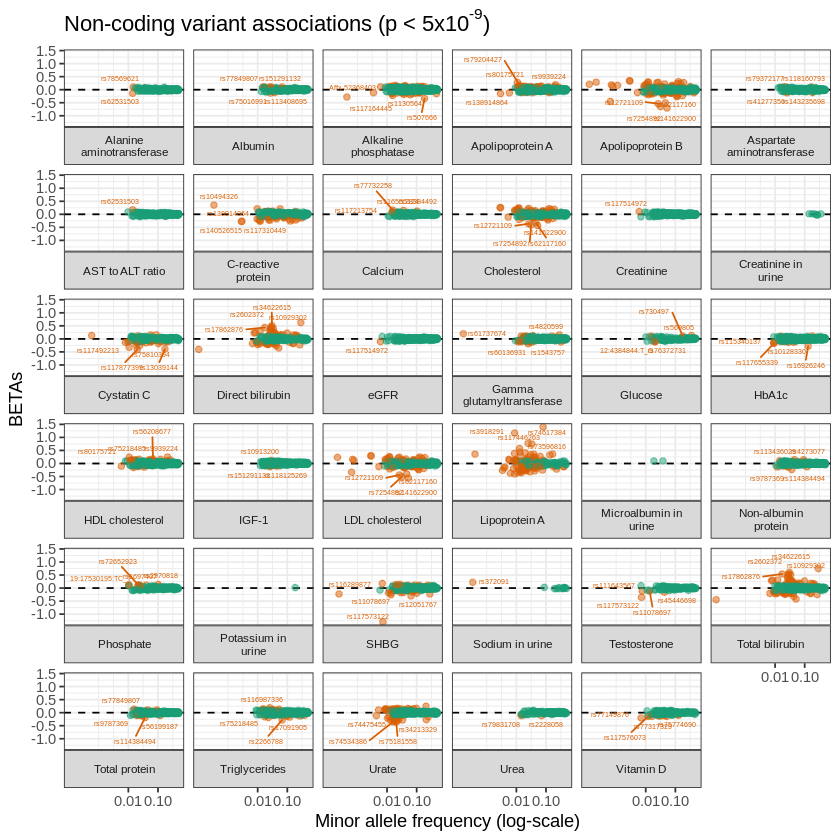

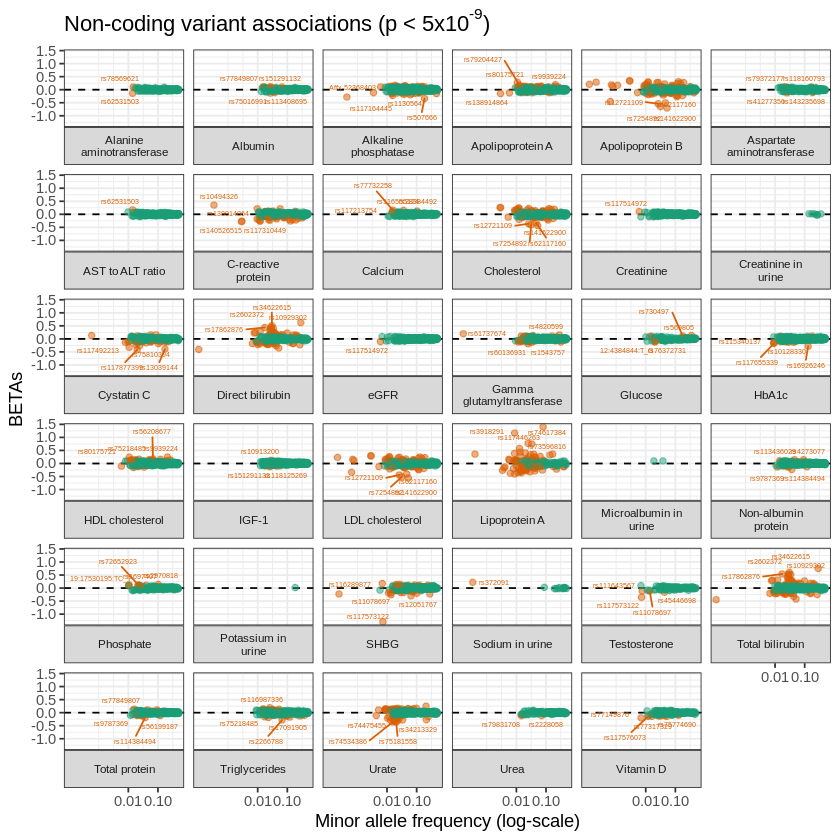

In [16]:
p.imp + ggsave(file.path(outd, "cascade.imp.png"), width = 10, height = 15)
p.imp + ggsave(file.path(outd, "cascade.imp.pdf"), width = 10, height = 15)
